---
### 📌 **BUSINESS UNDERSTANDING**
---

#### **Konteks**
Industri perhotelan sangat dipengaruhi oleh perilaku pemesanan customer atau tamu hotel. Perilaku ini dipengaruhi oleh beberapa faktor diantaranya faktor musiman (weekend, weekday, holiday), event (lokal & internasional), ekonomi, promosi serta diskon, dan lain sebagainya. Akibat ketidakpastian ini, pihak hotel harus memahami dan mengantisipasi perilaku customer yang berisiko merugikan hotel. Dalam hal ini, pembatalan reservasi yang berdampak pada operasional, manajemen, dan keuangan hotel. 

Tindakan antisipasi yang dapat dilakukan yakni memprediksi kemungkinan pembatalan reservasi oleh customer dengan memanfaatkan data historis pemesanan hotel sebelumnya. Dengan solusi ini, hotel dapat menghadapi ketidakpastian bisnis secara lebih siap, meningkatkan pendapatan, dan menjalankan strategi operasional yang lebih efektif dan efisien. Model prediksi pembatalan bukan hanya memberikan manfaat teknis, tetapi juga keunggulan kompetitif nyata dalam bisnis perhotelan.

Model ini dapat membantu **tim revenue, front office, general manager, marketing, serta tim operasional hotel** untuk mengambil keputusan operasional dan manajemen hotel. Prediksi ini dapat digunakan ketika proses reservasi masuk guna mencegah kerugian akibat pembatalan reservasi.

---
#### **Problem Statement**
Pembatalan reservasi baik secara mendadak maupun sepihak oleh customer berdampak pada manajemen, operasional, dan keuangan hotel. Prediksi yang salah terhadap reservasi dapat membuat hotel mengalami lost revenue dan overbooking. Pihak hotel yang berasumsi jumlah pembatalan reservasinya sedikit, berisiko mengalami kerugian (lost revenue) akibat meningkatnya jumlah kamar kosong. Disamping itu, pihak hotel yang berasumsi jumlah pembatalan reservasinya banyak, berisiko mengalami overbooking yang berdampak pada kekecewaan customer dan reputasi hotel.

---

#### **Tujuan**

Adapun tujuan dalam project ini yakni mengembangkan model prediksi pembatalan reservasi berdasarkan pola data historis dan perilaku tamu guna mengurangi risiko yang dapat merugikan pihak hotel. Selain itu, memberikan rekomendasi keputusan bisnis berdasarkan hasil prediksi model.

---

#### **Dampak Implementasi pada Proses Bisnis**

- **Efisiensi dan proaktivitas meningkat:** Risiko kamar kosong dan kerugian akibat pembatalan bisa ditekan sekaligus mengurangi risiko overbook
- **Keputusan manajemen semakin objektif dan data-driven:** Alokasi kamar, penjadwalan staf, penentuan harga, dan promosi berdasarkan output model dan bukan hanya berdasarkan intuisi semata (tanpa data)
- **Peningkatan pendapatan dan profitabilitas** 

---

In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import  roc_auc_score, roc_curve
from sklearn.metrics import classification_report


import pickle

---
### 📊 **DATA UNDERSTANDING**
---

In [177]:
df = pd.read_csv('data_hotel_booking_demand.csv')
df.head()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


In [178]:
info_df = pd.DataFrame({
    'Nama Kolom': df.columns,
    'Jumlah Data': df.count(),
    'Jumlah Missing': df.isnull().sum(),
    'Jumlah Data Unik': df.nunique(),
    'Tipe Data': df.dtypes  
}).reset_index(drop=True)

info_df.index += 1
info_df

,Nama Kolom,Jumlah Data,Jumlah Missing,Jumlah Data Unik,Tipe Data
1,country,83222,351,162,object
2,market_segment,83573,0,8,object
3,previous_cancellations,83573,0,15,int64
4,booking_changes,83573,0,19,int64
5,deposit_type,83573,0,3,object
6,days_in_waiting_list,83573,0,115,int64
7,customer_type,83573,0,4,object
8,reserved_room_type,83573,0,10,object
9,required_car_parking_spaces,83573,0,5,int64
10,total_of_special_requests,83573,0,6,int64


- **Jumlah Data     :** 83.573 data pemesanan kamar hotel 
- **Setiap Feature  :** Informasi yang relevan untuk memprediksi pembatalan reservasi

---
> #### **Distribusi Frekuensi Setiap Feature** 

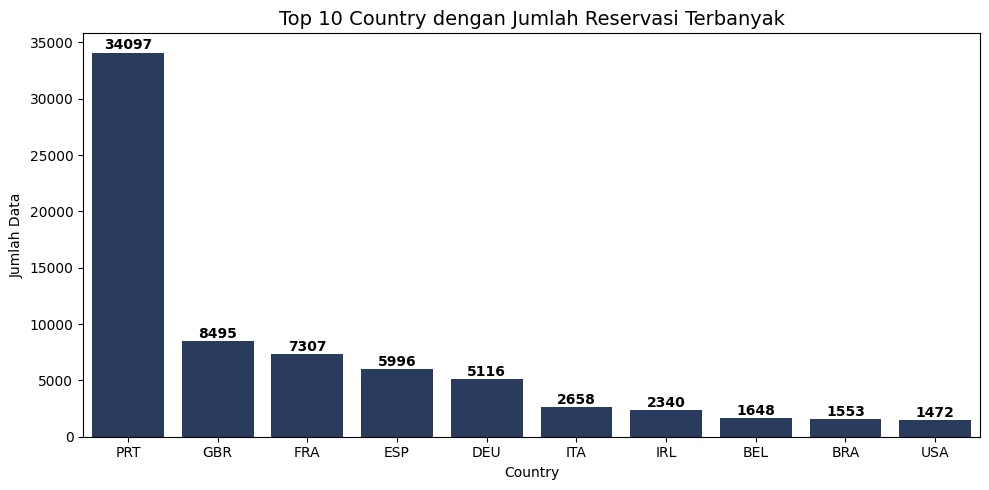

In [179]:
country_counts = df['country'].value_counts().head(10)

custom_colors = ['#213a65'] 
plt.figure(figsize=(10, 5))
sns.barplot(x=country_counts.index, y=country_counts.values, palette=custom_colors)

for i, val in enumerate(country_counts.values):
    plt.text(i, val + 10, str(val), ha='center', va='bottom', fontweight='bold')

plt.title('Top 10 Country dengan Jumlah Reservasi Terbanyak', fontsize=14)
plt.xlabel('Country')
plt.ylabel('Jumlah Data')
plt.tight_layout()
plt.show()

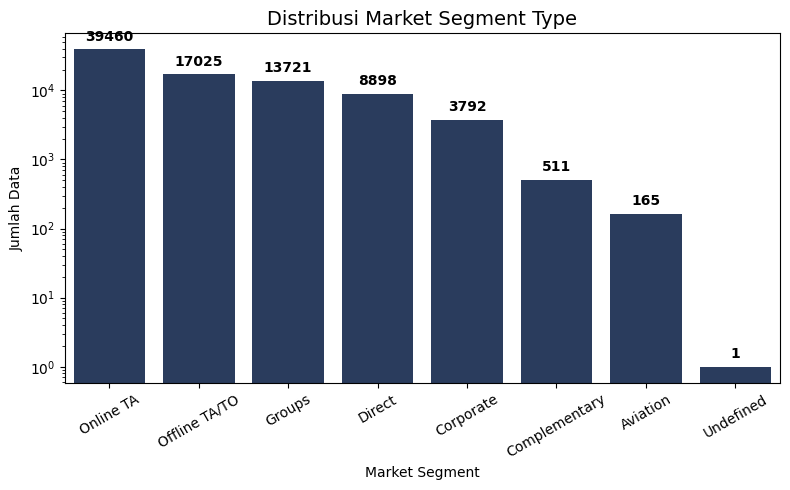

In [180]:
market_counts = df['market_segment'].value_counts()

custom_colors = ['#213a65']
plt.figure(figsize=(8, 5))
sns.barplot(x=market_counts.index, y=market_counts.values, palette=custom_colors)

for i, val in enumerate(market_counts.values):
    plt.text(i, val * 1.2, str(val), ha='center', va='bottom', fontweight='bold')

plt.title('Distribusi Market Segment Type', fontsize=14)
plt.xlabel('Market Segment')
plt.ylabel('Jumlah Data')
plt.yscale('log')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

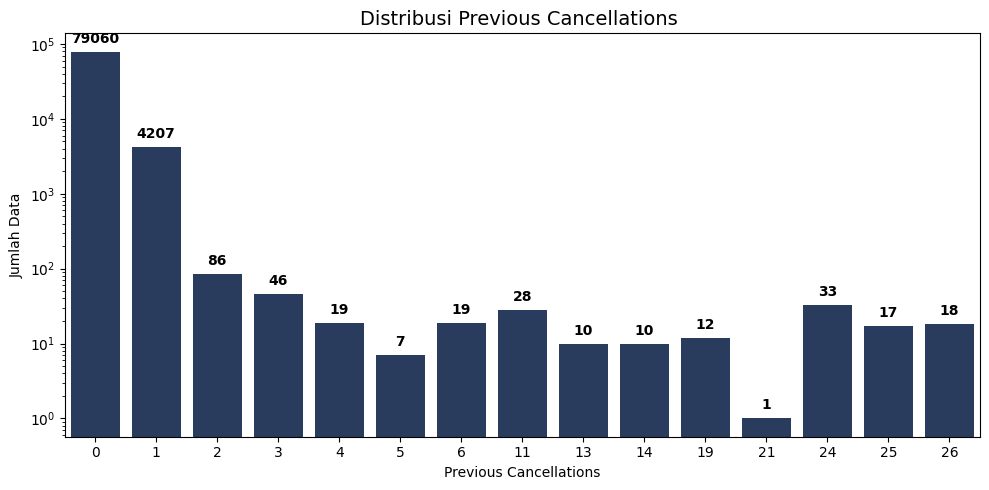

In [181]:
prev_cancel_counts = df['previous_cancellations'].value_counts().sort_index()

custom_colors = ['#213a65']
plt.figure(figsize=(10, 5))
sns.barplot(x=prev_cancel_counts.index, y=prev_cancel_counts.values, palette=custom_colors)

for i, val in enumerate(prev_cancel_counts.values):
    plt.text(i, val * 1.2, str(val), ha='center', va='bottom', fontweight='bold')

plt.yscale('log')
plt.title('Distribusi Previous Cancellations ', fontsize=14)
plt.xlabel('Previous Cancellations')
plt.ylabel('Jumlah Data')
plt.tight_layout()
plt.show()


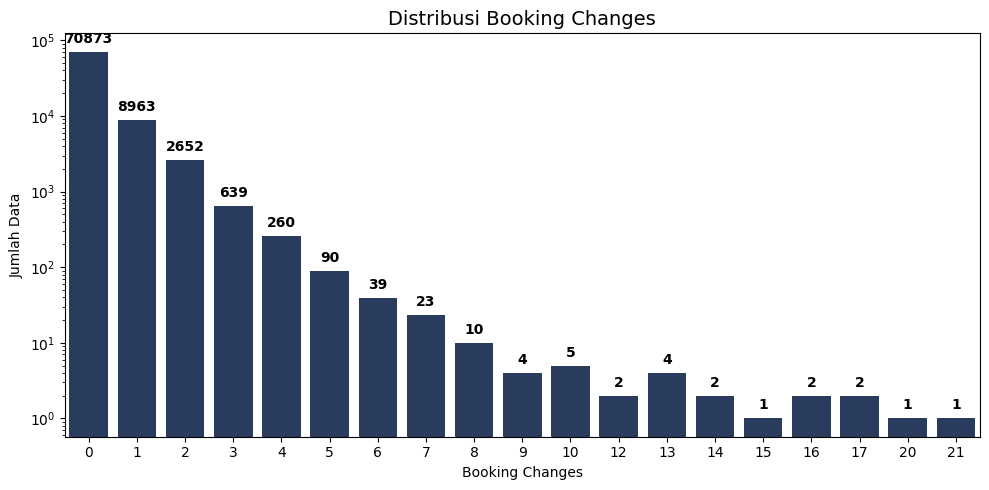

In [182]:
booking_changes_counts = df['booking_changes'].value_counts().sort_index()

custom_colors = ['#213a65']
plt.figure(figsize=(10, 5))
sns.barplot(x=booking_changes_counts.index, y=booking_changes_counts.values, palette=custom_colors)

for i, val in enumerate(booking_changes_counts.values):
    plt.text(i, val * 1.2, str(val), ha='center', va='bottom', fontweight='bold')

plt.yscale('log')
plt.title('Distribusi Booking Changes', fontsize=14)
plt.xlabel('Booking Changes')
plt.ylabel('Jumlah Data')
plt.tight_layout()
plt.show()

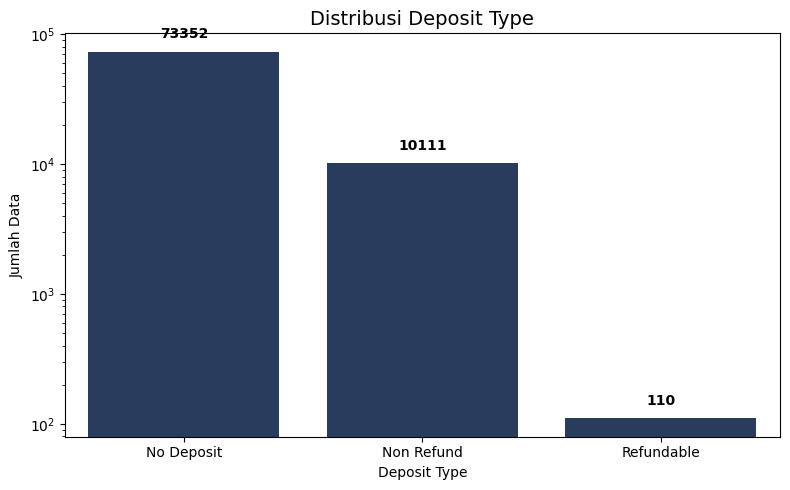

In [183]:
deposit_counts = df['deposit_type'].value_counts()

custom_colors = ['#213a65']
plt.figure(figsize=(8, 5))
sns.barplot(x=deposit_counts.index, y=deposit_counts.values, palette=custom_colors)

for i, val in enumerate(deposit_counts.values):
    plt.text(i, val * 1.2, str(val), ha='center', va='bottom', fontweight='bold')

plt.yscale('log')
plt.title('Distribusi Deposit Type', fontsize=14)
plt.xlabel('Deposit Type')
plt.ylabel('Jumlah Data')
plt.tight_layout()
plt.show()

In [184]:
days_in_waiting_list_count = df['days_in_waiting_list'].value_counts().reset_index()
days_in_waiting_list_count.columns = ['Days in Waiting List', 'Count']

days_in_waiting_list_count

,Days in Waiting List,Count
0,0,80988
1,39,166
2,58,104
3,44,93
4,31,93
...,...,...
110,74,1
111,121,1
112,36,1
113,64,1


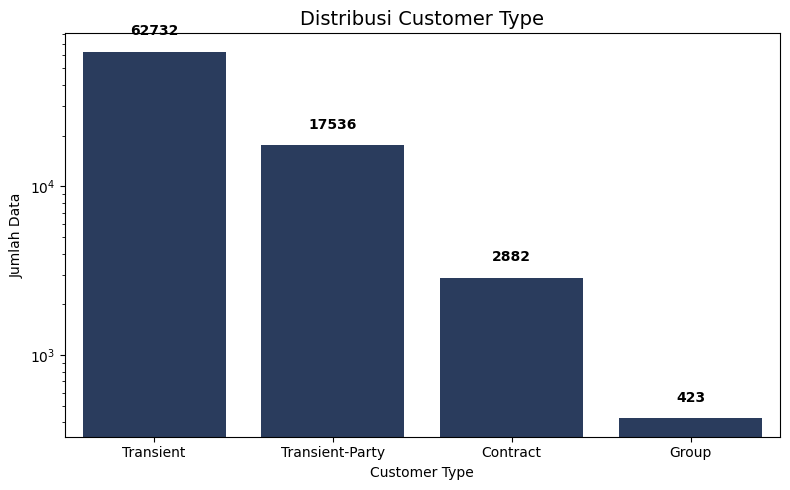

In [185]:
customer_counts = df['customer_type'].value_counts()

custom_colors = ['#213a65']
plt.figure(figsize=(8, 5))
sns.barplot(x=customer_counts.index, y=customer_counts.values, palette=custom_colors)

for i, val in enumerate(customer_counts.values):
    plt.text(i, val * 1.2, str(val), ha='center', va='bottom', fontweight='bold')

plt.yscale('log')
plt.title('Distribusi Customer Type', fontsize=14)
plt.xlabel('Customer Type')
plt.ylabel('Jumlah Data')
plt.tight_layout()
plt.show()

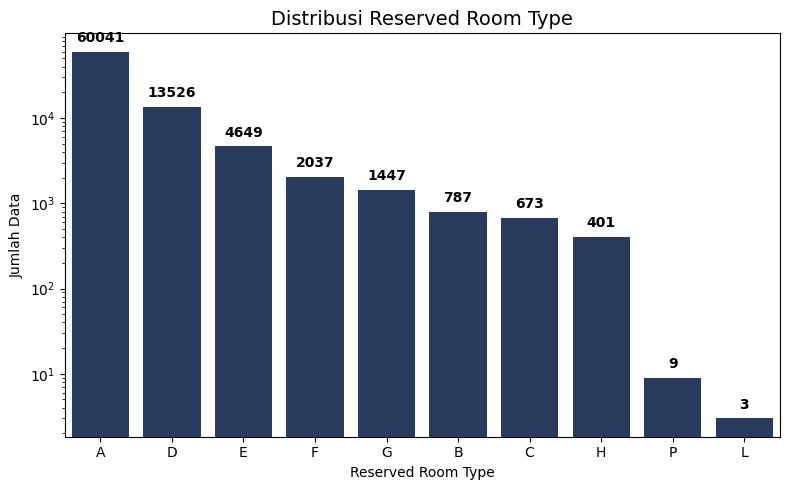

In [186]:
room_counts = df['reserved_room_type'].value_counts()

custom_colors = ['#213a65']
plt.figure(figsize=(8, 5))
sns.barplot(x=room_counts.index, y=room_counts.values, palette=custom_colors)

for i, val in enumerate(room_counts.values):
    plt.text(i, val * 1.2, str(val), ha='center', va='bottom', fontweight='bold')

plt.yscale('log')
plt.title('Distribusi Reserved Room Type', fontsize=14)
plt.xlabel('Reserved Room Type')
plt.ylabel('Jumlah Data')
plt.tight_layout()
plt.show()

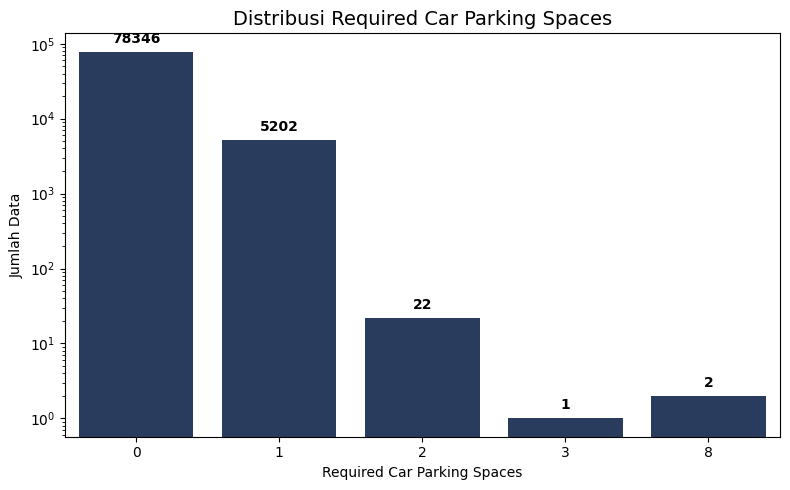

In [187]:
parking_counts = df['required_car_parking_spaces'].value_counts().sort_index()

custom_colors = ['#213a65']
plt.figure(figsize=(8, 5))
sns.barplot(x=parking_counts.index.astype(str), y=parking_counts.values, palette=custom_colors)

for i, val in enumerate(parking_counts.values):
    plt.text(i, val * 1.2, str(val), ha='center', va='bottom', fontweight='bold')

plt.yscale('log')
plt.title('Distribusi Required Car Parking Spaces', fontsize=14)
plt.xlabel('Required Car Parking Spaces')
plt.ylabel('Jumlah Data')
plt.tight_layout()
plt.show()

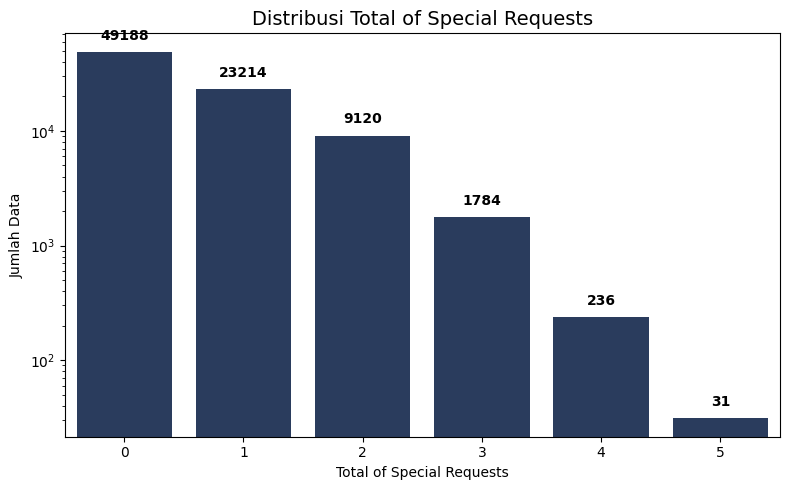

In [188]:
special_req_counts = df['total_of_special_requests'].value_counts().sort_index()

custom_colors = ['#213a65']
plt.figure(figsize=(8, 5))
sns.barplot(x=special_req_counts.index.astype(str), y=special_req_counts.values, palette=custom_colors)

for i, val in enumerate(special_req_counts.values):
    plt.text(i, val * 1.2, str(val), ha='center', va='bottom', fontweight='bold')

plt.yscale('log')
plt.title('Distribusi Total of Special Requests', fontsize=14)
plt.xlabel('Total of Special Requests')
plt.ylabel('Jumlah Data')
plt.tight_layout()
plt.show()

---
> #### **Target "is_canceled"**
Tujuan analisis dilakukan untuk memprediksi dan meminimalisir pembatalan pemesanan sehingga fokus pada informasi di kolom "is canceled"

| Nama Kolom    | Tipe Data | Deskripsi                                              | Kaitannya dengan Bisnis                                                                                                                                                                            |
| ------------- | --------- | ------------------------------------------------------ | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `is_canceled` | int64     | Status pembatalan (1: Canceled, 0: Not Canceled) | **Target prediksi utama dalam project ini** <br> Untuk mengukur tingkat pembatalan reservasi, memahami pola pembatalan, dan menjadi dasar pengambilan keputusan untuk strategi bisnis hotel |

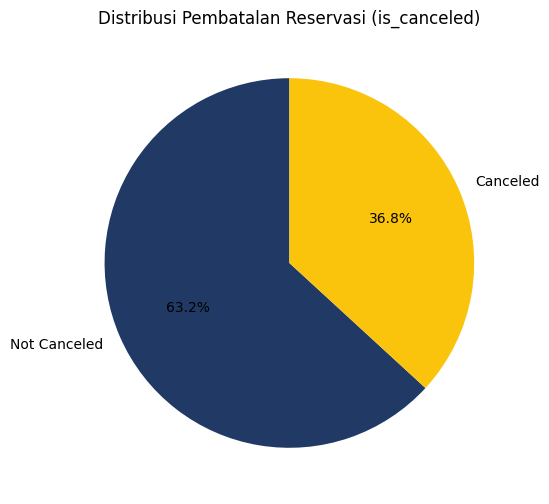

In [189]:
plt.figure(figsize=(6, 6))
df['is_canceled'].value_counts().plot.pie(
    autopct='%1.1f%%', 
    labels=['Not Canceled', 'Canceled'],
    startangle=90,
    colors=['#213a65', '#fac40d']
)
plt.title('Distribusi Pembatalan Reservasi (is_canceled)')
plt.ylabel('')
plt.show()

**Berdasarkan visualisasi pie chart di atas ditemukan bahwa distribusi kelas tidak seimbang (Imbalanced Class Distribution)**

Kolom **is_canceled** yang menjadi target (label Y) dalam pemodelan machine learning memiliki distribusi kelas yang tidak seimbang (imbalanced).

- **63.2%** data termasuk kategori **"Not Canceled"** (reservasi berhasil dilakukan).
- **36.8%** data termasuk kategori **"Canceled"** (reservasi dibatalkan).

Ketidakseimbangan ini dapat berdampak pada proses pelatihan model machine learning, karena algoritma cenderung belajar lebih baik pada kelas mayoritas dan mengabaikan kelas minoritas. Dalam kasus ini, model bisa jadi memiliki akurasi tinggi hanya karena sering menebak "Not Canceled", tetapi kinerjanya buruk dalam mengenali kasus pembatalan reservasi (False Negative tinggi).

**Dalam analisis ini, kelas 1 (Canceled) menjadi fokus utama dalam evaluasi model, yakni memprioritaskan Recall untuk menekan jumlah pembatalan yang tidak terdeteksi.**

---
### 🔄 **DATA PREPROCCESING**
---

> #### **Cleaning**

In [190]:
# Imputasi Missing Value pada Feature Country

df['country'] = df['country'].fillna('Other')
df.isnull().sum()

country_count = df['country'].value_counts().reset_index()
country_count.columns = ['Country', 'Count']

country_count

,Country,Count
0,PRT,34097
1,GBR,8495
2,FRA,7307
3,ESP,5996
4,DEU,5116
...,...,...
158,DMA,1
159,KIR,1
160,MYT,1
161,KNA,1


In [191]:
dupes = df.duplicated()
print("Jumlah baris duplikat:", dupes.sum())

Jumlah baris duplikat: 73371


Dataset ini **duplikatnya ekstrim** ==> dari 83.573 baris , **88%** (73.371) **data sama persis**

Tidak dapat dipastikan apakah data duplikat ini adalah kondisi sebenarnya atau error input karena tidak ada keterangan lebih lanjut mengenai dataset.
Data duplikat ini berisiko membuat model overfitting dan bias sehingga lebih baik datanya di drop. 

In [192]:
# Menghapus Data Duplikat

df.drop_duplicates(inplace=True)
df.duplicated().sum()
print("Jumlah Data :", df.shape)

Jumlah Data : (10202, 11)


**Setelah data di drop, dari 83.573 baris tersisa 10.202 baris**

---
> #### **FEATURE SELECTION & FEATURE ENGINEERING**

In [193]:
# Mengkategorikan Feature Country menjadi 3 Jenis

def group_country(x):
    if x == 'PRT':
        return 'Portugal'
    elif x == 'Other':
        return 'Other'
    else:
        return 'Non Portugal'
df['country_grouped'] = df['country'].apply(group_country)

In [194]:
# Menyiapkan Feature yang akan dilakukan Encode

categorical_cols = ['country_grouped', 'market_segment', 'deposit_type', 'customer_type']
ordinal_col = ['reserved_room_type']
numerical_cols = [
    'previous_cancellations',
    'booking_changes',
    'days_in_waiting_list',
    'required_car_parking_spaces',
    'total_of_special_requests'
]

In [195]:
# Encode Feature: Pipeline Preprocessing FS & FE 
# Feature Categorical           => OneHot Encoder
# Feature reserved room type    => Ordinal Encoder
# Feature Numerical             => Robust Scaler

room_order = [['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'L','P']]

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(sparse_output=False), categorical_cols),
    ('ord', OrdinalEncoder(categories=room_order), ordinal_col),
    ('num', RobustScaler(), numerical_cols)
])

X_features = categorical_cols + ordinal_col + numerical_cols
processed_array = preprocessor.fit_transform(df[X_features])

In [196]:
# Hasil Encoding Menghasilkan Total 24 Feature (tanpa target) 

onehot_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([
    onehot_feature_names,
    ['reserved_room_type_ordinal'],
    numerical_cols
])
 

df_final = pd.DataFrame(processed_array, columns=all_feature_names, index=df.index)

df_final['is_canceled'] = df['is_canceled'].values

df_final.columns = df_final.columns.str.replace(' ', '_')

df_final.columns

Index(['country_grouped_Non_Portugal', 'country_grouped_Other',
       'country_grouped_Portugal', 'market_segment_Aviation',
       'market_segment_Complementary', 'market_segment_Corporate',
       'market_segment_Direct', 'market_segment_Groups',
       'market_segment_Offline_TA/TO', 'market_segment_Online_TA',
       'market_segment_Undefined', 'deposit_type_No_Deposit',
       'deposit_type_Non_Refund', 'deposit_type_Refundable',
       'customer_type_Contract', 'customer_type_Group',
       'customer_type_Transient', 'customer_type_Transient-Party',
       'reserved_room_type_ordinal', 'previous_cancellations',
       'booking_changes', 'days_in_waiting_list',
       'required_car_parking_spaces', 'total_of_special_requests',
       'is_canceled'],
      dtype='object')

Setelah dilakukan tahapan data preprocessing, termasuk encoding pada variabel kategorikal dengan teknik One-Hot Encoding, numerikal dengan Robust Scaler, reserved room type dengan ordinal encoding, jumlah fitur pada dataset mengalami peningkatan.

**📌 Total feature setelah preprocessing yakni 25 kolom yang terdiri dari:**
- **24 fitur input (hasil encoding + ordinal + numerikal)**
- **1 fitur target (is_canceled)**

Selanjutnya, feature ini siap digunakan dalam proses pemodelan machine learning untuk memprediksi apakah suatu reservasi akan dibatalkan atau tidak.

---
### 🤖 **MODELING**
---

> #### **ANALYTICS (ALGORITHM & EVALUATION METRICS)** 

In [197]:
X = df_final.drop(columns='is_canceled')
y = df_final['is_canceled']

In [198]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Proporsi target di train:", y_train.value_counts(normalize=True))
print("Proporsi target di test :", y_test.value_counts(normalize=True))


Train shape: (7141, 24) Test shape: (3061, 24)
Proporsi target di train: is_canceled
0    0.763338
1    0.236662
Name: proportion, dtype: float64
Proporsi target di test : is_canceled
0    0.763476
1    0.236524
Name: proportion, dtype: float64


|                              | **Prediksi: Not Canceled (0)**                                                                   | **Prediksi: Canceled (1)**                                                                             |
| ---------------------------- | ----------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------- |
| **Aslinya: Not Canceled (0)** | **True Negative (TN)** – Model benar: reservasi Not Canceled dan diprediksi Not Canceled          | **False Positive (FP)** – Model salah: reservasi seharusnya Not Canceled, tapi diprediksi akan Canceled |
| **Aslinya: Canceled (1)**       | **False Negative (FN)** – Model salah: reservasi benar-benar Canceled, tapi diprediksi Not Canceled | **True Positive (TP)** – Model benar: reservasi Canceled dan diprediksi Canceled                          |

**Dalam menemukan model yang paling baik, Recall menjadi fokus utama pemilihan model.** Hal ini sejalan dengan tujuan awal yakni untuk mendapatkan model yang bisa memprediksi customer/tamu hotel yang mungkin akan membatalkan reservasinya. Khususnya pada tamu yang terlihat akan datang namun nyatanya membatalkan reservasinya (False Negative). **Kasus FN ini paling berisiko tinggi pada operasional dan manajemen hotel sehingga pengendalian FN ini menjadi fokus utama prediksi.**

**Semakin tinggi recall, semakin sedikit FN yang lolos dari deteksi model.** Oleh karena itu, model dievaluasi dan dipilih berdasarkan performanya dalam meminimalkan FN melalui peningkatan recall, meskipun mungkin harus mengorbankan sedikit nilai precision atau accuracy secara keseluruhan.

---
> #### **MODEL - LOGISTIC REGRESSION**

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.94      0.87      2337
           1       0.61      0.31      0.41       724

    accuracy                           0.79      3061
   macro avg       0.71      0.62      0.64      3061
weighted avg       0.76      0.79      0.76      3061

Confusion Matrix:
 [[2193  144]
 [ 503  221]]


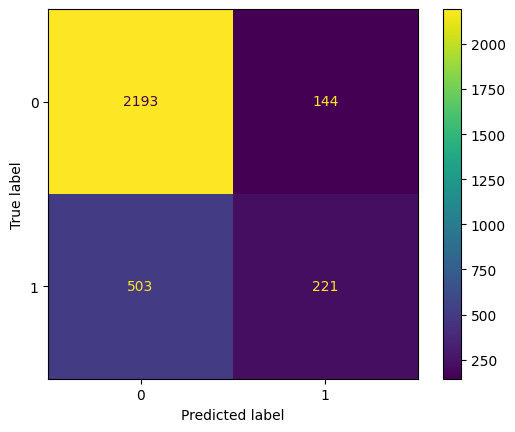

In [199]:
# Train logistic regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# Predict
y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:, 1] 

# Evaluasi hasil
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test)
plt.show()

> #### **MODEL – KNN**

Classification Report (KNN):
               precision    recall  f1-score   support

           0       0.82      0.87      0.84      2337
           1       0.48      0.37      0.42       724

    accuracy                           0.75      3061
   macro avg       0.65      0.62      0.63      3061
weighted avg       0.74      0.75      0.74      3061

Confusion Matrix (KNN):
 [[2039  298]
 [ 453  271]]


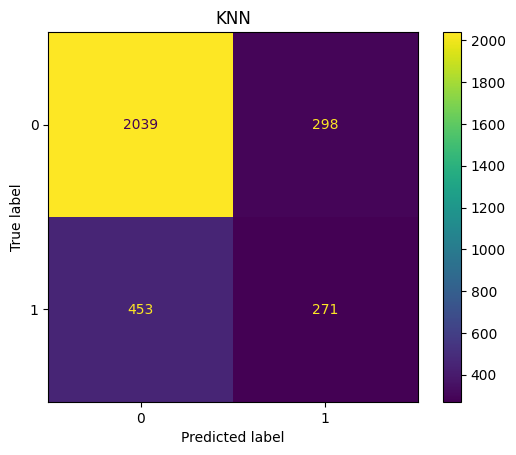

In [200]:
# Train KNN
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Predict
y_pred_knn = knn.predict(X_test)
y_proba_knn = knn.predict_proba(X_test)[:, 1]

# Evaluasi hasil
print("Classification Report (KNN):\n", classification_report(y_test, y_pred_knn))
print("Confusion Matrix (KNN):\n", confusion_matrix(y_test, y_pred_knn))
ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test)
plt.title("KNN")
plt.show()

> #### **MODEL – DECISION TREE**

Classification Report (Decision Tree):
               precision    recall  f1-score   support

           0       0.82      0.88      0.85      2337
           1       0.48      0.36      0.42       724

    accuracy                           0.76      3061
   macro avg       0.65      0.62      0.63      3061
weighted avg       0.74      0.76      0.75      3061

Confusion Matrix (Decision Tree):
 [[2055  282]
 [ 460  264]]


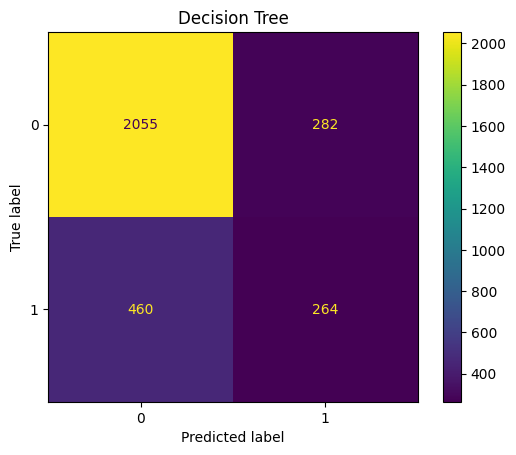

In [201]:
# Train Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Predict
y_pred_dt = dt.predict(X_test)
y_proba_dt = dt.predict_proba(X_test)[:, 1]

# Evaluasi hasil
print("Classification Report (Decision Tree):\n", classification_report(y_test, y_pred_dt))
print("Confusion Matrix (Decision Tree):\n", confusion_matrix(y_test, y_pred_dt))
ConfusionMatrixDisplay.from_estimator(dt, X_test, y_test)
plt.title("Decision Tree")
plt.show()

> #### **MODEL – RANDOM FOREST**

Classification Report (Random Forest):
               precision    recall  f1-score   support

           0       0.82      0.88      0.85      2337
           1       0.49      0.37      0.42       724

    accuracy                           0.76      3061
   macro avg       0.66      0.63      0.64      3061
weighted avg       0.74      0.76      0.75      3061

Confusion Matrix (Random Forest):
 [[2066  271]
 [ 459  265]]


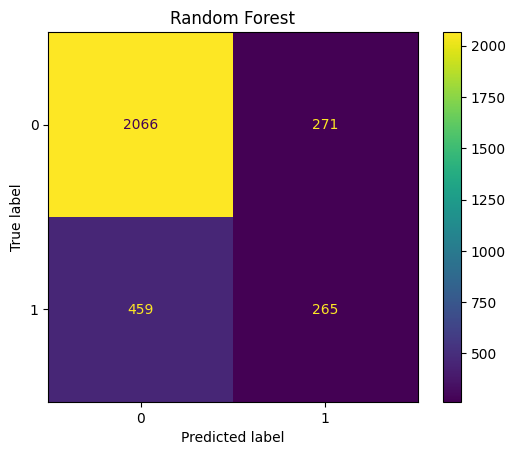

In [202]:
# Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

# Evaluasi hasil
print("Classification Report (Random Forest):\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix (Random Forest):\n", confusion_matrix(y_test, y_pred_rf))
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)
plt.title("Random Forest")
plt.show()

> #### **MODEL – XGBoost**

Classification Report (XGBoost):
               precision    recall  f1-score   support

           0       0.82      0.92      0.87      2337
           1       0.59      0.35      0.43       724

    accuracy                           0.79      3061
   macro avg       0.70      0.63      0.65      3061
weighted avg       0.76      0.79      0.77      3061

Confusion Matrix (XGBoost):
 [[2161  176]
 [ 474  250]]


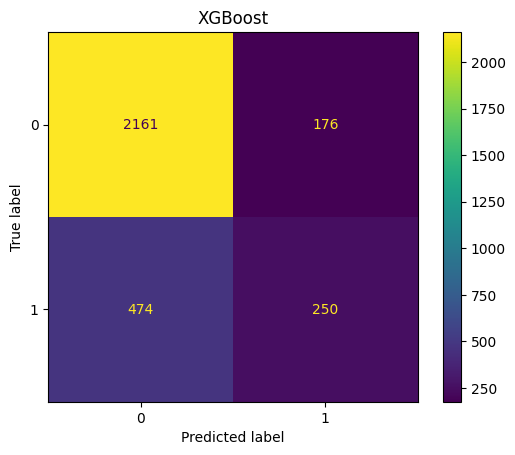

In [203]:
# Train XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

# Evaluasi hasil
print("Classification Report (XGBoost):\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix (XGBoost):\n", confusion_matrix(y_test, y_pred_xgb))
ConfusionMatrixDisplay.from_estimator(xgb, X_test, y_test)
plt.title("XGBoost")
plt.show()

**🔎 Analisis Hasil Model**

Tabel perbandingan classification report untuk kelas 1 (canceled):

| Model           | Accuracy | Precision (1)     | Recall (1)     | F1-Score (1)     | 
| --------------- | -------- | ----------------- | -------------- | ---------------- | 
| LogisticReg     | 0.79     | 0.61              | 0.31           | 0.41             | 
| KNN             | 0.75     | 0.48              | 0.37           | 0.42             | 
| Decision Tree   | 0.76     | 0.48              | 0.36           | 0.42             | 
| Random Forest   | 0.76     | 0.49              | 0.37           | 0.42             | 
| XGBoost         | 0.79     | 0.59              | 0.35           | 0.43             | 

**Performa antar model relatif serupa** dan belum memberikan hasil yang benar-benar optimal, terutama dalam mendeteksi kelas "canceled".
Khususnya pada recall dan accuracy yang menjadi fokus utama dalam kasus ini. Tidak ada satu model yang secara signifikan lebih unggul dibandingkan yang lain. 

Untuk meningkatkan kinerja model, khususnya dalam mendeteksi pembatalan reservasi (**kelas 1**), dilakukan proses **Hyperparameter Tuning**. Dengan mengatur parameter model secara lebih optimal, diharapkan hasil prediksi dapat meningkat baik dari segi **recall** maupun **Accuracy**. Langkah ini akan membantu kita memilih **model terbaik secara lebih akurat dan terpercaya**.

---

> #### **Hyperparameter Tuning**

Hyperparameter yang dituning antara lain:
- n_estimators: jumlah pohon yang digunakan.
- max_depth: kedalaman maksimum setiap pohon.
- learning_rate: seberapa besar langkah tiap update model.
- subsample: proporsi data yang digunakan pada setiap pohon.
- colsample_bytree: proporsi fitur yang digunakan pada setiap pohon.
- gamma: minimum loss reduction sebelum pemisahan.

In [204]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1]
}

**Tuning dilakukan menggunakan GridSearchCV dengan scoring='Recall'**
<br>
Pemilihan scoring recall sesuai dengan tujuan bisnis, yaitu meminimalkan False Negative pada kelas pembatalan reservasi.

In [205]:
# Model XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='recall',
    cv=3,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Recall Score:", grid_search.best_score_)

# Evaluasi Model Hasil Tuning
best_xgb = grid_search.best_estimator_
y_pred_best = best_xgb.predict(X_test)
y_proba_best = best_xgb.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred_best))
print(confusion_matrix(y_test, y_pred_best))

Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best Recall Score: 0.38341542479708085
              precision    recall  f1-score   support

           0       0.82      0.92      0.86      2337
           1       0.56      0.35      0.43       724

    accuracy                           0.78      3061
   macro avg       0.69      0.63      0.65      3061
weighted avg       0.76      0.78      0.76      3061

[[2140  197]
 [ 472  252]]


In [206]:
# Model Random Forest
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced', None]
}

rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring='recall',
    cv=3,
    n_jobs=-1,
    verbose=1
)
grid_search_rf.fit(X_train, y_train)
print("Best Parameters RF:", grid_search_rf.best_params_)
print("Best Recall Score RF:", grid_search_rf.best_score_)

# Evaluasi Model Hasil Tuning
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters RF: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Recall Score RF: 0.8526689173584604
              precision    recall  f1-score   support

           0       0.94      0.67      0.78      2337
           1       0.45      0.85      0.59       724

    accuracy                           0.72      3061
   macro avg       0.69      0.76      0.68      3061
weighted avg       0.82      0.72      0.74      3061

[[1575  762]
 [ 109  615]]


In [207]:
# Model Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

param_grid_dt = {
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced', None]
}

dt = DecisionTreeClassifier(random_state=42)
grid_search_dt = GridSearchCV(
    estimator=dt,
    param_grid=param_grid_dt,
    scoring='recall',
    cv=3,
    n_jobs=-1,
    verbose=1
)
grid_search_dt.fit(X_train, y_train)
print("Best Parameters DT:", grid_search_dt.best_params_)
print("Best Recall Score DT:", grid_search_dt.best_score_)

# Evaluasi Model Hasil Tuning
best_dt = grid_search_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test)
print(classification_report(y_test, y_pred_dt))
print(confusion_matrix(y_test, y_pred_dt))


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters DT: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best Recall Score DT: 0.8621398788153636
              precision    recall  f1-score   support

           0       0.95      0.65      0.77      2337
           1       0.44      0.88      0.58       724

    accuracy                           0.70      3061
   macro avg       0.69      0.76      0.68      3061
weighted avg       0.82      0.70      0.72      3061

[[1513  824]
 [  88  636]]


In [208]:
# Model Logistic Regression
from sklearn.linear_model import LogisticRegression

param_grid_lr = {
    'C': [0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear'],
    'class_weight': ['balanced', None],
    'penalty': ['l2']
}

lr = LogisticRegression(random_state=42, max_iter=1000)
grid_search_lr = GridSearchCV(
    estimator=lr,
    param_grid=param_grid_lr,
    scoring='recall',
    cv=3,
    n_jobs=-1,
    verbose=1
)
grid_search_lr.fit(X_train, y_train)
print("Best Parameters LR:", grid_search_lr.best_params_)
print("Best Recall Score LR:", grid_search_lr.best_score_)

# Evaluasi Model Hasil Tuning
best_lr = grid_search_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters LR: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
Best Recall Score LR: 0.8278241773007654
              precision    recall  f1-score   support

           0       0.93      0.67      0.78      2337
           1       0.44      0.83      0.57       724

    accuracy                           0.71      3061
   macro avg       0.68      0.75      0.68      3061
weighted avg       0.81      0.71      0.73      3061

[[1571  766]
 [ 124  600]]


In [209]:
# Model KNN
from sklearn.neighbors import KNeighborsClassifier

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1=manhattan, 2=euclidean
}

knn = KNeighborsClassifier()
grid_search_knn = GridSearchCV(
    estimator=knn,
    param_grid=param_grid_knn,
    scoring='recall',
    cv=3,
    n_jobs=-1,
    verbose=1
)
grid_search_knn.fit(X_train, y_train)
print("Best Parameters KNN:", grid_search_knn.best_params_)
print("Best Recall Score KNN:", grid_search_knn.best_score_)

# Evaluasi Model Hasil Tuning
best_knn = grid_search_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test)
print(classification_report(y_test, y_pred_knn))
print(confusion_matrix(y_test, y_pred_knn))


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters KNN: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Best Recall Score KNN: 0.4414221768724622
              precision    recall  f1-score   support

           0       0.81      0.84      0.83      2337
           1       0.43      0.38      0.40       724

    accuracy                           0.73      3061
   macro avg       0.62      0.61      0.62      3061
weighted avg       0.72      0.73      0.73      3061

[[1972  365]
 [ 448  276]]


**🔎 Analisis Hasil**

| Model            | Accuracy | Precision (1) | Recall (1) | F1-score (1) |
|------------------|----------|---------------|------------|-------------|
| XGBoost          | 0.78     | 0.56          | 0.35       | 0.43        |
| **Random Forest**    | **0.72**     | **0.45**          | **0.85**       | **0.59**        |
| **Decision Tree**    | **0.70**    | **0.44**         | **0.88**       | **0.58**        |
| Logistic Reg     | 0.71     | 0.44          | 0.83       | 0.57        |
| KNN              | 0.73     | 0.43          | 0.38       | 0.40        |


Setelah dilakukan proses Hyperparameter Tuning terhadap lima model machine learning, terdapat peningkatan pada recall. Artinya kemampuan model dalam mendeteksi kasus pembatalan reservasi (kelas 1) menjadi lebih baik.

Model yang menunjukkan performa yang baik, yakni:
- **Decision Tree** memiliki recall tertinggi (0.88), yang berarti sangat baik dalam mengenali pembatalan reservasi. Meskipun accuracy-nya sedikit lebih rendah (0.70), performa ini sangat cocok jika fokus utamanya adalah menekan jumlah False Negative (FN).
- **Random Forest** juga menunjukkan performa yang kuat dengan recall 0.85 dan sedikit lebih tinggi accuracy-nya dibanding Decision Tree (0.72), menjadikannya alternatif terbaik jika ingin sedikit lebih seimbang.

---

**Model Random Forest dipilih sebagai model terbaik dengan pertimbangan:**
- Memiliki **recall yang tinggi (0.85)**, sesuai dengan fokus utama yaitu mengenali pembatalan reservasi dengan baik dan menekan False Negative
- **Accuracy lebih tinggi (0.72)** dibandingkan Decision tree (0.70), lebih seimbang sensitivitas dan akurasinya 
- **F1-score paling tinggi (0.59)**, artinya model lebih stabil dan realistis saat mendeteksi pembatalan reservasi, lebih relevan untuk data imbalanced

**Model Random Forest menunjukkan bahwa tidak hanya sensitif dalam mendeteksi pembatalan, tetapi juga cukup akurat secara keseluruhan sehingga cocok digunakan walaupun kondisi datanya imbalance.**

---


> #### **Confusion Matrix Random Forest**

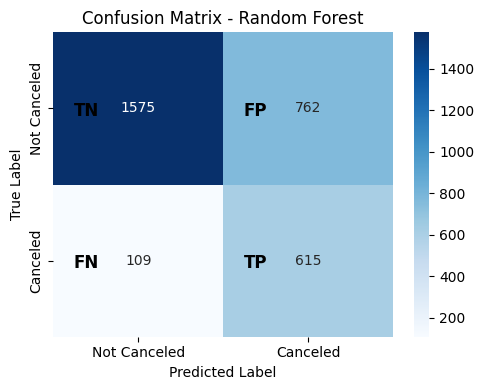

In [ ]:
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred_rf)


labels = np.array([["TN", "FP"], ["FN", "TP"]])

plt.figure(figsize=(5,4))
ax = sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Not Canceled', 'Canceled'],
    yticklabels=['Not Canceled', 'Canceled'],
    cbar=True
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Random Forest')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j+0.12, i+0.55, labels[i, j], color='black', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


**Hasil evaluasi**
- True Negative (TN): Reservasi yang benar-benar tidak batal dan berhasil diprediksi tidak batal oleh model (1575 kasus).
- False Positive (FP): Reservasi yang sebenarnya tidak batal, tetapi diprediksi batal oleh model (762 kasus).
- False Negative (FN): Reservasi yang sebenarnya batal, tetapi diprediksi tidak batal oleh model (109 kasus).
- True Positive (TP): Reservasi yang benar-benar batal dan berhasil diprediksi batal oleh model (615 kasus).
---

> #### **Feature Importance**

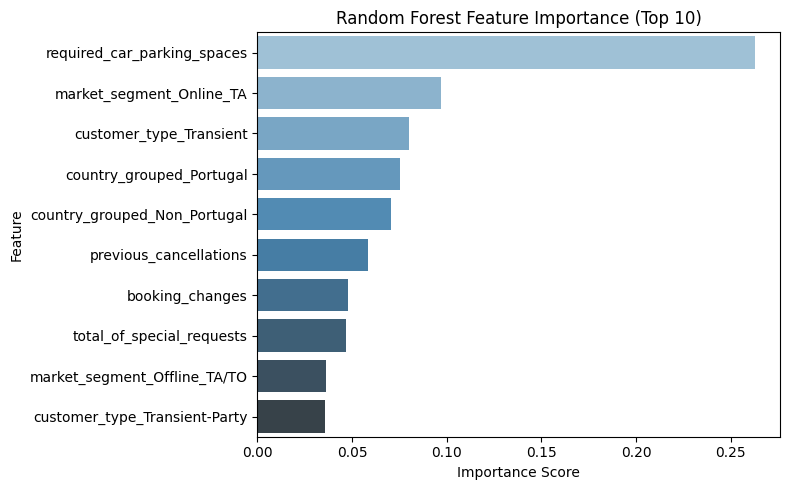

In [ ]:
feature_names = X_train.columns

importances = best_rf.feature_importances_

feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(8, 5))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feat_imp.head(10),  #hanya menampilkan 10 feature teratas
    palette='Blues_d'
)
plt.title('Random Forest Feature Importance (Top 10)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Berdasarkan hasil evaluasi feature importance pada model Random Forest, terdapat beberapa variabel yang sangat berpengaruh dalam prediksi pembatalan reservasi hotel. **Fitur required_car_parking_spaces adalah faktor paling dominan**, artinya permintaan ruang parkir yang tinggi cenderung berhubungan dengan pola reservasi tertentu, termasuk kemungkinan pembatalan. Diikuti oleh segmentasi market seperti (**market_segment_Online_TA** dan **market_segment_Offline_TA/TO**), tipe pelanggan (**customer_type_Transient** dan **customer_type_Transient-Party**), asal negara (**country_grouped_Portugal atau country_grouped_Non_Portugal**), riwayat cancel reservasi (**previous_cancellations**), perubahan reservasi (**booking_changes**), serta jumlah permintaan khusus (**total_of_special_request**).

Temuan ini baik bagi hotel untuk membuat suatu strategi mitigasi yang bersifat personal pada variabel kunci. 

---
> #### **Curve ROC & AUC**

ROC AUC Score: 0.83


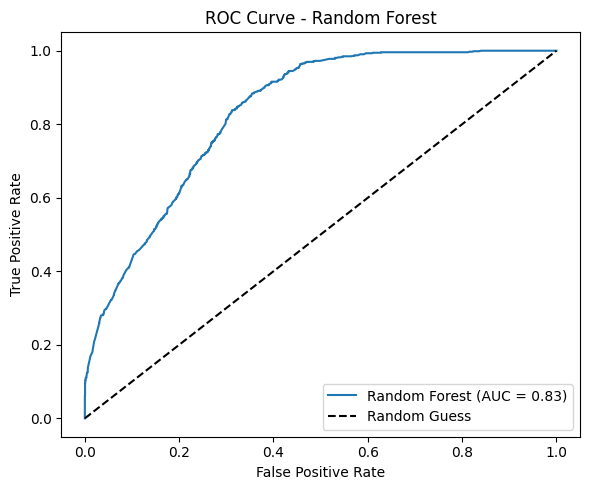

In [ ]:
# Prediksi probabilitas untuk kelas positif (canceled = 1)
y_proba_rf = best_rf.predict_proba(X_test)[:,1]

roc_auc = roc_auc_score(y_test, y_proba_rf)
print(f'ROC AUC Score: {roc_auc:.2f}')

fpr, tpr, thresholds = roc_curve(y_test, y_proba_rf)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

Berdasarkan hasil evaluasi menggunakan ROC Curve, model Random Forest menunjukkan kemampuan yang sangat baik dalam membedakan antara reservasi hotel yang akan dibatalkan dan yang tidak dibatalkan. Nilai AUC (Area Under Curve) sebesar 0.83 menunjukkan bahwa model memiliki tingkat diskriminasi yang kuat. Artinya dalam 83% kasus, model mampu memberikan skor probabilitas yang lebih tinggi pada reservasi yang benar-benar batal dibandingkan reservasi yang tidak batal. Semakin mendekati angka 1, semakin baik performa model dalam mengklasifikasikan kedua kelas tersebut.

Kurva ROC pada grafik juga memperlihatkan bahwa model konsisten menjaga keseimbangan antara true positive rate (sensitivitas) dan false positive rate pada berbagai ambang prediksi (threshold). Hal ini menandakan bahwa model tidak hanya andal pada satu titik threshold tertentu, tapi tetap stabil dalam berbagai skenario.

**Dengan nilai AUC 0.83, model Random Forest sangat layak digunakan sebagai sistem prediksi pembatalan reservasi hotel, karena dapat membantu manajemen hotel untuk mengidentifikasi risiko secara lebih akurat dan mengambil keputusan mitigasi yang lebih efektif.**

---
## 📢 **CONCLUSION & RECOMMENDATION**
---

### **Conclusion**

- **Model Random Forest dipilih sebagai model terbaik** dengan mempertimbangkan besar **recall (85%)**, **accuracy (59%)**, **F1-score (59%)**. Dengan begitu, model ini sensitif dalam mendeteksi pembatalan dan cukup akurat walaupun pada kondisi data yang imbalance. 
- Nilai **AUC (Area Under Curve) sebesar 0.83** menunjukkan bahwa model memiliki tingkat diskriminasi yang kuat. Dengan demikian, model Random Forest sangat layak digunakan sebagai sistem prediksi pembatalan reservasi hotel.
- Feature yang paling berpengaruh dalam memprediksi pembatalan reservasi adalah **required_car_parking_spaces**, artinya permintaan ruang parkir yang tinggi cenderung berhubungan dengan kemungkinan pembatalan. 
- Model ini berhasil memprediksi pembatalan reservasi hotel guna meminimalisasi risiko kerugian finansial, membantu pengambilan keputusan tim revenue management dan front office hotel, serta mengoptimalkan operasional hotel. Hal ini didukung oleh hasil simulasi perhitungan laba yang menunjukkan bahwa **laba meningkat 5 kali lipat dan lebih realistis ketika menggunakan model ini untuk prediksi**. 

---

### **Recommendation**

- **Model ini paling efektif digunakan sebagai sistem peringatan dini (early warning)** ketika reservasi baru masuk sehingga hotel dapat segera menyiapkan langkah mitigasi
- **Sangat baik digunakan pada periode high season atau event** dengan potensi pembatalan tinggi karena model terbukti mampu menekan kerugian akibat kamar kosong dan overbook
- **Membuat strategi yang bersifat personal pada customer yang karakteristiknya berisiko untuk melakukan pembatalan reservasi** agar dapat membantu pengambilan keputusan terhadap promosi, penentuan harga, penjadwalan staf, dan pengalokasian kamar oleh tim revenue, marketing, dan front office hotel
- Hotel perlu memperhatikan permintaan lahan parkir dari customer untuk mencegah risiko pembatalan
- Membuat strategi dan perhatian khusus pada negara dengan kecenderungan tinggi melakukan pembatalan, misalnya dengan membuat konten pemasaran lokal yang lebih edukatif dan informatif.

---

> #### **Saving Model**

In [213]:
with open('rf_model_final.pkl', 'wb') as file:
    pickle.dump(best_rf, file)

print("Model berhasil disimpan dengan pickle!")

Model berhasil disimpan dengan pickle!
